**Nuclei segmentation in whole slide H&E images**

using custom model.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [4]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
import os
from glob import glob

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles'  # path of ndpi files
WSIs = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\*.ndpi'))

pth_mat = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\10x\matfiles'
crop_mats = [_ for _ in os.listdir(pth_mat) if _.endswith('mat')]

In [6]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)

    offset = 1024/4 + 1024/8
    crop_width = 256
    crop_height = 256
    crop_x = int(data['crop_x']*ratio + offset)
    crop_y = int(data['crop_y']*ratio)

    return (crop_x, crop_y, crop_width)

In [7]:
ind = 0

mat_file_path = os.path.join(pth_mat, crop_mats[ind])
res20x=0.4416
res10x=1
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

Run next cell if you have lots of memory and want to store multiple ndpis in RAM --> so probably don't run

In [37]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 1

# you might need to run "pip install imagecodecs" if you get jpeg compression error

imgs = list(map(imread, WSIs))
n_channel = 1 if imgs[0].ndim == 2 else imgs[0].shape[-1]  #If no third

# axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

imgs = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(imgs)]

Normalizing image channels jointly.


MemoryError: Unable to allocate 12.6 GiB for an array with shape (30976, 36480, 3) and data type float32

Run this one instead to load just 1 ndpi in RAM

In [8]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 1

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

# axis_norm = (0,1)   # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

img = normalize(img,1,99.8,axis=axis_norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


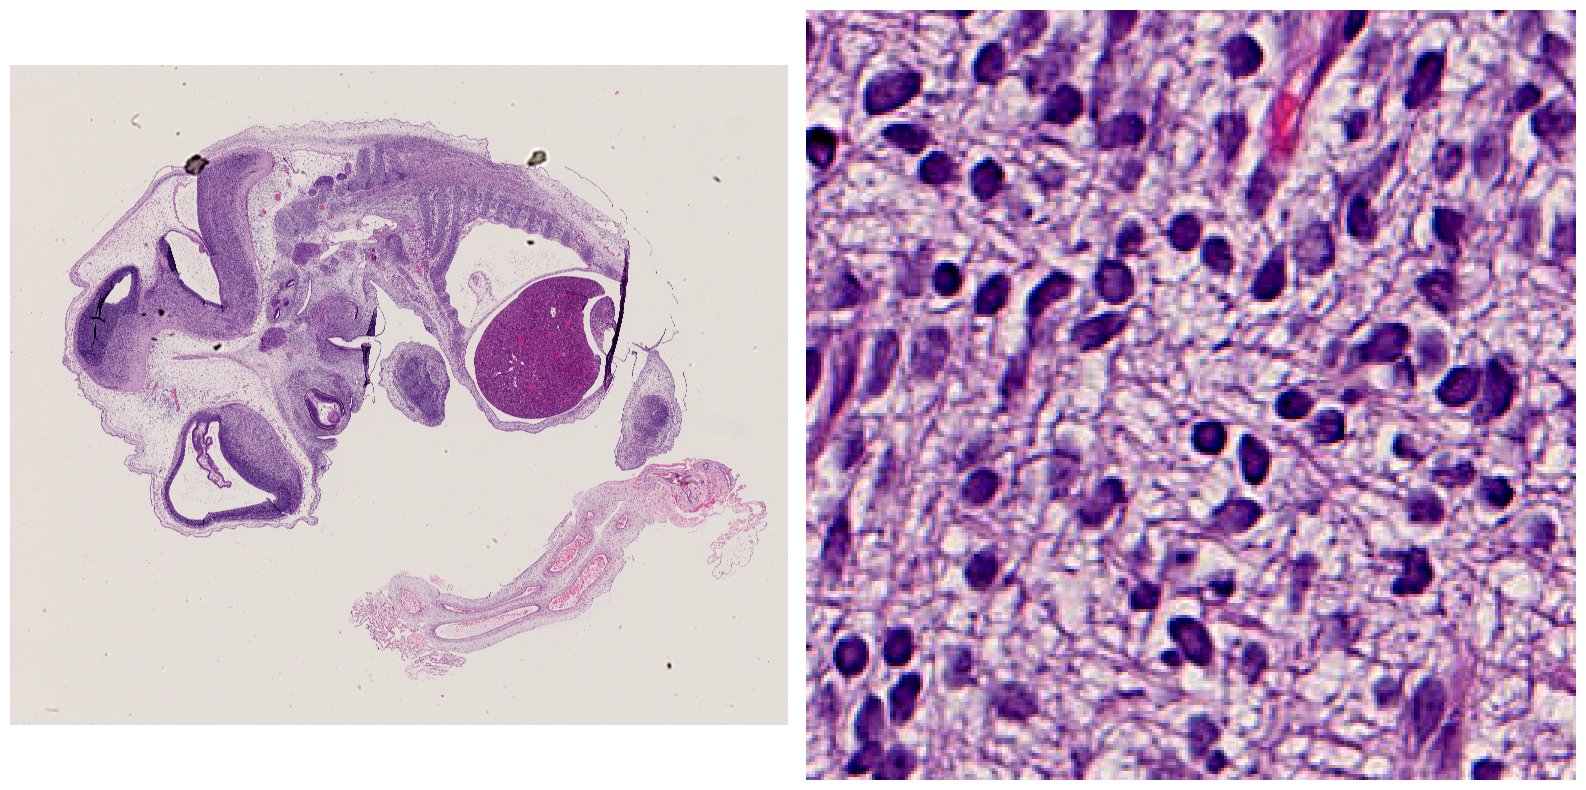

In [9]:
show_image(img, crop_x, crop_y, tile_size)

In [10]:
model = StarDist2D(None, name='monkey_tile_trained', basedir=r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\stardist_models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.593187, nms_thresh=0.3.


In [11]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
#Slow - takes time to segment the large image

# img = imgs[ind]

labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 90/90 [03:33<00:00,  2.38s/it]


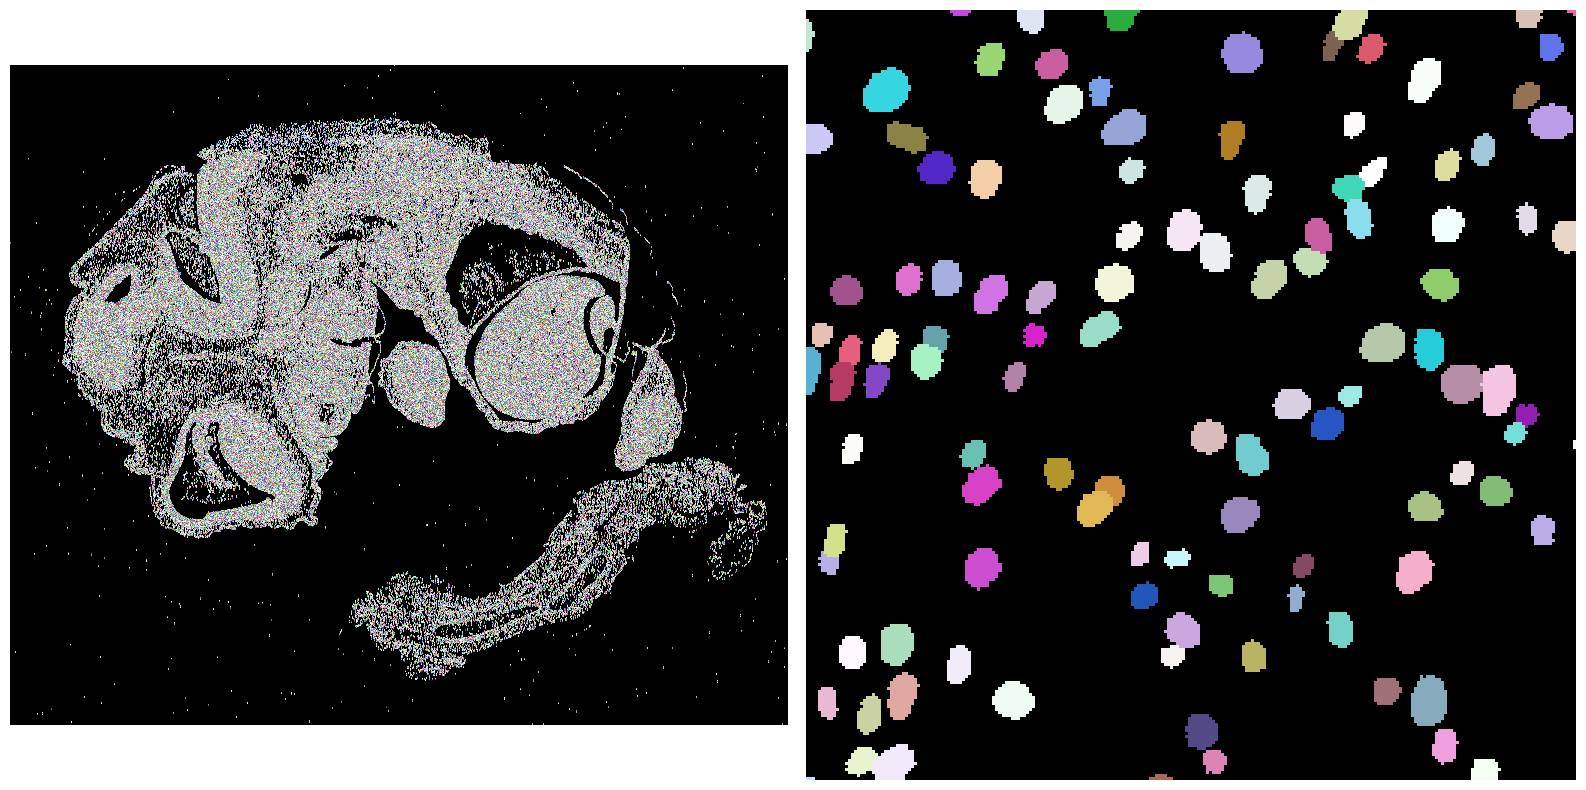

In [14]:
show_image(labels, crop_x, crop_y, tile_size, cmap=cmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


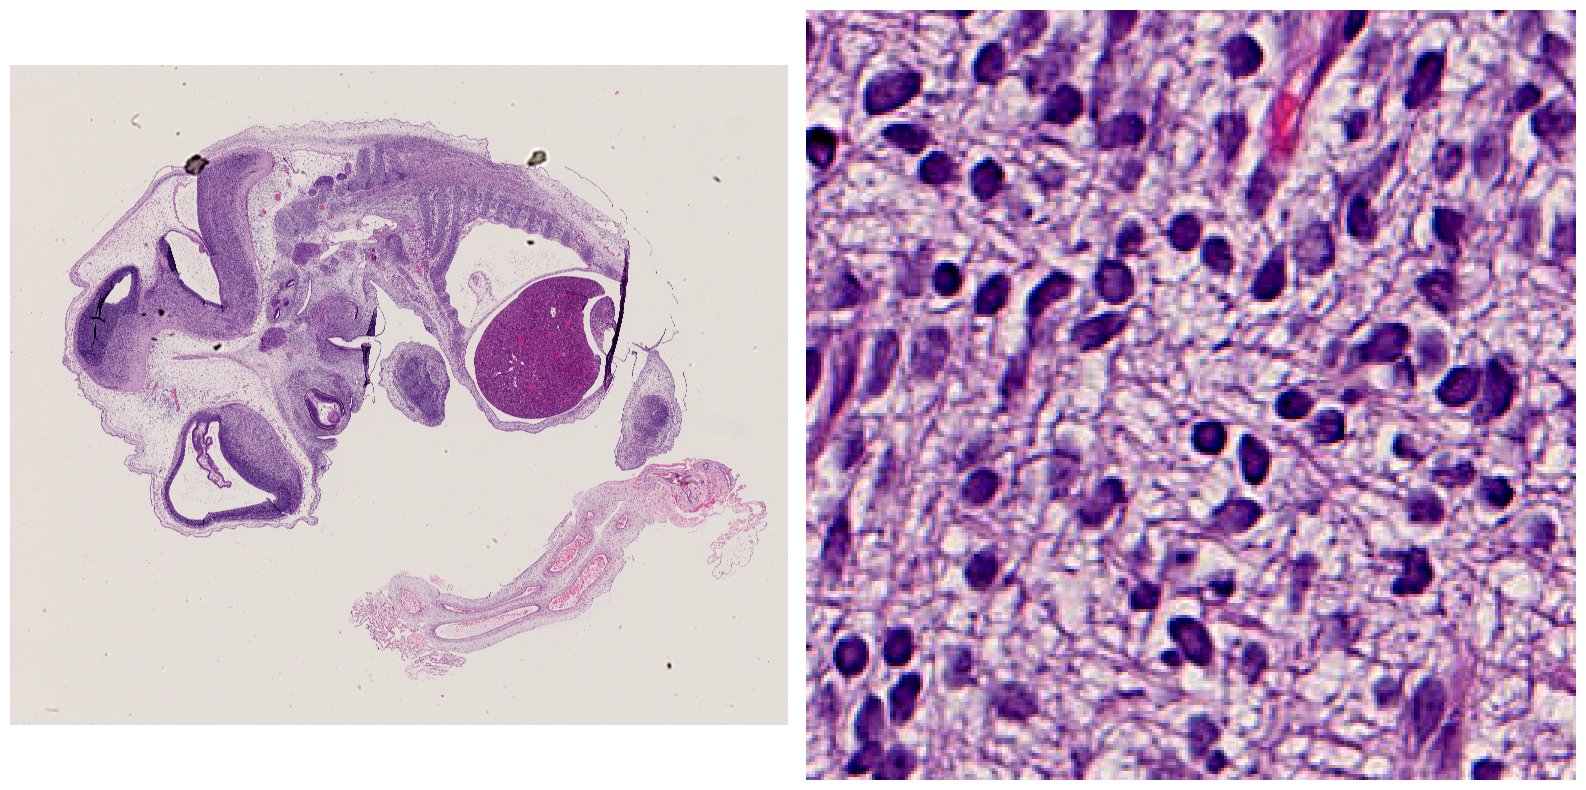

In [15]:
show_image(img, crop_x, crop_y, tile_size, cmap=cmap)

In [16]:
#cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
#cropped_lbl = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

cropped_img = img[crop_y+tile_size:crop_y+tile_size*2, crop_x+tile_size:crop_x+tile_size*2]
cropped_lbl = labels[crop_y+tile_size:crop_y+tile_size*2, crop_x+tile_size:crop_x+tile_size*2]

lbl_cmap = random_label_cmap()

In [18]:
tile_size

256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


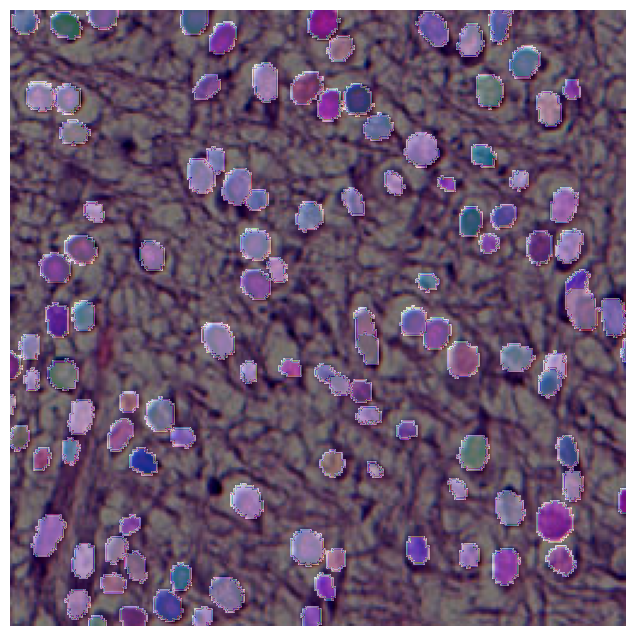

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')
plt.show()